In [1]:
#Import functions and models to pass to those functions
import paths as p
import functions_model_testing as f
import os
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Create new folder to save the images without background
if os.path.isdir(p.new_path) == False:
    os.mkdir(p.new_path)

#Walk through the folder of the images and save it in the new folder without background
for folder, subfolders, filenames in os.walk(p.data_path):
    for img in filenames:
        if os.path.isfile(p.new_path + '/' + img) == False:
            image_path = folder + '/' + img
            remove_background(image_path, p.new_path)
        else:
            pass

In [3]:
#dict with models that are going to be tested and the image size they require as a tuple (model, size) (Different models may require different image sizes)
test_models = {
    #"resnet": (models.resnet18(pretrained=True), 224),
    #"alexnet": (models.alexnet(pretrained=True), 224),
    "vgg16": (models.vgg16(pretrained=True), 224),
    # "densenet": (models.densenet161(pretrained=True), 224),
    # "inception": (models.inception_v3(pretrained=True), 299),
    #"googlenet": (models.googlenet(pretrained=True), 224),
}

In [4]:
#Create a dict with the features for each model and metric combination
sorted_sim_per_model = {}
for model_name in test_models:
    for metrics in ['cosine', 'euclidean', 'manhattan']:
 
        model, size = test_models[model_name]
        model = f.get_encoder(model_name)
        features = f.features_extraction(model, p.data_path, size=size)
        sorted_similarities = f.similarity_extraction(p.input_path, features, method=metrics)
        sorted_sim_per_model[model_name + '_' + metrics] = sorted_similarities

AttributeError: module 'functions_model_testing' has no attribute 'get_encoder'

In [5]:
#Rank the best recommendations for each model
ranks = f.ranking_similarities(sorted_sim_per_model, top_n=10)

#Create a rank fusion of all individuals rankings
final_dict = f.reciprocal_rank_fusion(ranks)

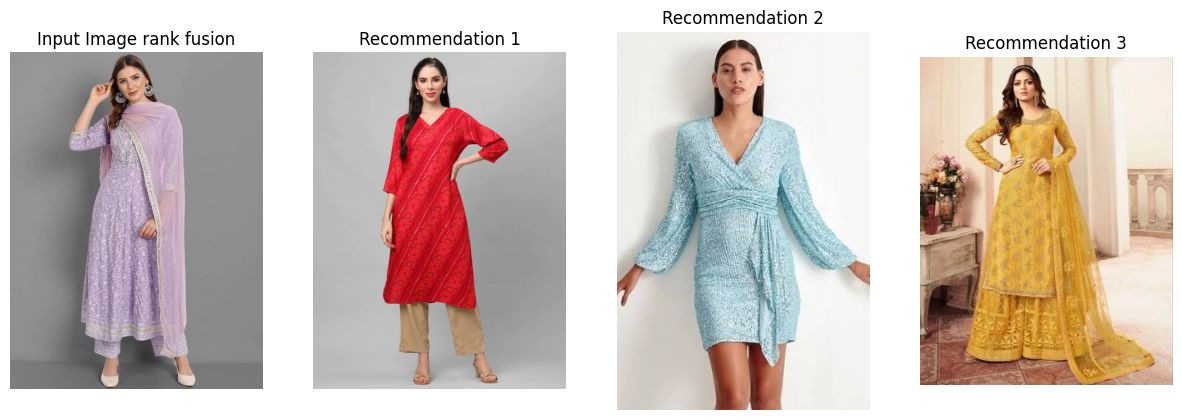

In [6]:
#Show the recommendations for this image
f.plot_recommendations(final_dict, p.input_path, model_name="rank fusion", top_n=3)